In [1]:
import pandas as pd
import numpy as np
import librosa as lr
import matplotlib.pyplot as plt
from scipy.signal.signaltools import wiener
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import pywt

In [2]:
files = lr.util.find_files(r'C:\Users\markm\Desktop\bones_data') 
files = np.asarray(files)
len(files)

444

In [3]:
#initialize audio data 
output_list = [0]*117 + [1]*120 + [0]*207

In [4]:
targetframe = pd.DataFrame({'path':files, 'output':output_list})

In [5]:
targetframe

,path,output
0,C:\Users\markm\Desktop\bones_data\Maria_hand_f...,0
1,C:\Users\markm\Desktop\bones_data\Maria_hand_f...,0
2,C:\Users\markm\Desktop\bones_data\Maria_hand_f...,0
3,C:\Users\markm\Desktop\bones_data\Maria_hand_f...,0
4,C:\Users\markm\Desktop\bones_data\Maria_hand_f...,0
...,...,...
439,C:\Users\markm\Desktop\bones_data\Stas_head_zi...,0
440,C:\Users\markm\Desktop\bones_data\Stas_head_zi...,0
441,C:\Users\markm\Desktop\bones_data\Stas_head_zi...,0
442,C:\Users\markm\Desktop\bones_data\Stas_head_zi...,0


In [6]:
class AudioFeatures:
    def __init__(self, files, path_column, sample_rate=16000):
        self.files = files
        self.path_column = path_column
        self.sample_rate = sample_rate
        self.audios = []
        self.features = []
        
    def extract_all_features(self):
        self.load()
        self.energy_normalize()
        self.get_features()
        return self.create_features_df()
        
    def load(self):
        for path in range(len(self.path_column)):
            audio, sample_rate = lr.load(self.path_column.values[path], 
                                         sr = self.sample_rate)
            self.audios.append(audio)
    def energy_normalize(self):
         for i, audio in enumerate(self.audios):
            w_audio = wiener(audio)
            current_energy = np.sum(w_audio ** 2)
            self.audios[i] = w_audio / np.sqrt(current_energy)
    def get_features(self):
        for audio in self.audios:
            stft = np.abs(lr.stft(audio))
            result = np.array([])
            chroma = np.mean(lr.feature.chroma_stft(S=stft, sr=self.sample_rate).T, axis=0)
            result = np.hstack((result, chroma))
            mel = np.mean(lr.feature.melspectrogram(audio, sr=self.sample_rate).T, axis=0)
            result = np.hstack((result, mel))
            contrast = np.mean(lr.feature.spectral_contrast(S=stft, sr=self.sample_rate).T, axis=0)
            result = np.hstack((result, contrast))
            cA, cD = pywt.dwt(audio, 'db1')
            result = np.hstack((result, [cA.mean(), cD.mean()]))
            self.features.append(result)
    def create_features_df(self):
        column_names = []
        for j in range(147):
            if j < 12: column_names.append('chroma_' + str(j))
            elif j >= 12  and j < 140: column_names.append('mel_' + str(j-12))
            else: column_names.append('contrast_' + str(j-140))
        column_names.append('wavelet_cA')
        column_names.append('wavelet_cD')
        featuresframe = pd.DataFrame(self.features, columns = np.array(column_names))
        return featuresframe

In [7]:
AF = AudioFeatures(files, targetframe.path)
featuresframe = AF.extract_all_features()
featuresframe['path'] = files
featuresframe.head()

E:\Anaconda\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
E:\Anaconda\lib\site-packages\scipy\signal\signaltools.py:1475: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
E:\Anaconda\lib\site-packages\scipy\signal\signaltools.py:1475: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


,chroma_0,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,...,contrast_0,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,wavelet_cA,wavelet_cD,path
0,0.632079,0.529796,0.545900,0.505762,0.517238,0.553138,0.481255,0.637571,0.516364,0.537102,...,17.337019,24.908236,30.876651,18.964371,18.914433,18.760497,13.073751,0.000081,1.513449e-09,C:\Users\markm\Desktop\bones_data\Maria_hand_f...
1,0.594664,0.466061,0.493480,0.454627,0.496202,0.534354,0.469201,0.685500,0.508953,0.491237,...,18.635553,26.206566,30.159046,19.636376,17.346977,18.997591,13.265693,0.000020,-1.966753e-07,C:\Users\markm\Desktop\bones_data\Maria_hand_f...
2,0.624867,0.486126,0.502495,0.464540,0.492716,0.548291,0.493582,0.669318,0.530182,0.502750,...,19.255570,25.967992,30.345703,19.313075,18.645173,19.179313,13.232155,0.000037,2.318190e-07,C:\Users\markm\Desktop\bones_data\Maria_hand_f...
3,0.589826,0.438803,0.471486,0.462928,0.547951,0.605022,0.505054,0.725907,0.519484,0.463850,...,18.775563,23.933087,29.808447,19.991412,18.331584,18.510110,13.105874,0.000031,2.108760e-07,C:\Users\markm\Desktop\bones_data\Maria_hand_f...
4,0.643045,0.570014,0.523268,0.516824,0.600332,0.681074,0.527220,0.713372,0.569016,0.631481,...,17.722464,23.870836,28.071499,19.540765,19.294940,18.441520,12.708895,0.000001,2.092521e-07,C:\Users\markm\Desktop\bones_data\Maria_hand_f...


In [8]:
merged_dataframe = pd.merge(featuresframe, targetframe, on='path')
merged_dataframe.shape

(444, 151)

In [9]:
merged_dataframe.head()

,chroma_0,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,...,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,wavelet_cA,wavelet_cD,path,output
0,0.632079,0.529796,0.545900,0.505762,0.517238,0.553138,0.481255,0.637571,0.516364,0.537102,...,24.908236,30.876651,18.964371,18.914433,18.760497,13.073751,0.000081,1.513449e-09,C:\Users\markm\Desktop\bones_data\Maria_hand_f...,0
1,0.594664,0.466061,0.493480,0.454627,0.496202,0.534354,0.469201,0.685500,0.508953,0.491237,...,26.206566,30.159046,19.636376,17.346977,18.997591,13.265693,0.000020,-1.966753e-07,C:\Users\markm\Desktop\bones_data\Maria_hand_f...,0
2,0.624867,0.486126,0.502495,0.464540,0.492716,0.548291,0.493582,0.669318,0.530182,0.502750,...,25.967992,30.345703,19.313075,18.645173,19.179313,13.232155,0.000037,2.318190e-07,C:\Users\markm\Desktop\bones_data\Maria_hand_f...,0
3,0.589826,0.438803,0.471486,0.462928,0.547951,0.605022,0.505054,0.725907,0.519484,0.463850,...,23.933087,29.808447,19.991412,18.331584,18.510110,13.105874,0.000031,2.108760e-07,C:\Users\markm\Desktop\bones_data\Maria_hand_f...,0
4,0.643045,0.570014,0.523268,0.516824,0.600332,0.681074,0.527220,0.713372,0.569016,0.631481,...,23.870836,28.071499,19.540765,19.294940,18.441520,12.708895,0.000001,2.092521e-07,C:\Users\markm\Desktop\bones_data\Maria_hand_f...,0


In [10]:
X_train, X_test, y_train, y_test = train_test_split(merged_dataframe.drop(columns = ['path', 'output']),
                                                    merged_dataframe.output, test_size=0.3, random_state=5)
parametrs = {'n_estimators':range(5,41,5), 'max_depth':range(1,7),
    'min_samples_leaf':range(1,8), 'min_samples_split':range(2,4)}
voice_rf = RandomForestClassifier(random_state=0)
search = GridSearchCV(voice_rf, parametrs, n_jobs=-1, cv=5)
search.fit(X_train,y_train)
best_voice_forest = search.best_estimator_

In [11]:
predictions = best_voice_forest.predict(X_test)
scores = cross_val_score(best_voice_forest, merged_dataframe.drop(columns = ['path', 'output']), 
                         merged_dataframe.output, cv=5)
print(f'Accuracy: {(predictions == y_test.to_numpy()).sum()}/{len(predictions)}')
print('Cross-validation score: ', scores.mean())

Accuracy: 130/134
Cross-validation score:  0.8718845760980592


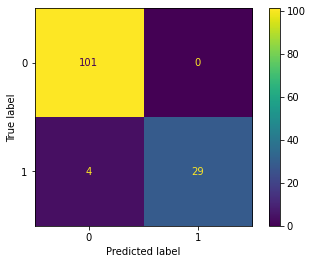

In [12]:
plot_confusion_matrix(best_voice_forest, X_test, y_test)  
plt.show()

FAR = 4 <br>
FRR = 0

Control Test

In [21]:
def control_check(folder_name):
    control_files = lr.util.find_files((r'C:\Users\markm\Desktop\\{}').format(folder_name)) 
    control_files = np.asarray(control_files)
    control_pathes = pd.DataFrame({'path':control_files})
    control_AF = AudioFeatures(control_files, control_pathes.path)
    control_features = control_AF.extract_all_features()
    control_predictions = best_voice_forest.predict(control_features)
    return control_files, control_predictions

In [ ]:
#in place of ... need to write name of the desktop folder, where control test sample are
control_check('...')